# En este notebook se hace un primer análisis de random forest para 50 árboles de decisión con la representación vectorial TF-IDF

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

pylab.rcParams['figure.figsize'] = 6, 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

import scipy.sparse
# Cargamos la matriz TF-IDF
#matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/proyecto/TFIDF.npz')#clara
matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/Colab Notebooks/proyecto/TFIDF.npz')#jorge

# Cargar el vectorizador TF-IDF
tfidf = joblib.load('/content/drive/My Drive/Colab Notebooks/proyecto/tfidf_vectorizer.joblib')

Mounted at /content/drive


### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media

# Dividimos los datos en conjunto de entrenamiento y de test, features (X) y labels (y)

X_train, X_test, y_train, y_test = train_test_split(matriz_tfidf, target, test_size=0.2, random_state=42)

# Reducir el tamaño del conjunto de datos
sample_size = 1000  # Número de muestras
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***2.1 Modelo de regresión con técnica de librería Scikit Learn***

##### *2.1.3 Random Forest*

In [ ]:
#para random forest no hay que normalizar los datos

In [ ]:
#hacemos reducción de muestras tanto con select kbest como coger las muestras de forma aleatoria
#dos métodos para comparar los resultados, no estudiamos cual sería el mejor nº de muestras si no para un nº de muestras cual es el
#mejor modelo, por tiempo de computo

In [ ]:
#para que sea más eficiente por la cantidad de datos de entrenamiento
#SelectKBest es una técnica que selecciona las K mejores características de un conjunto de características según un criterio de evaluación. En este caso "f-regression"

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_components = 500  # Número de componentes principales que quieres conservar
k_best = SelectKBest(f_regression, k=n_components)  # Selecciona las 500 mejores características

In [ ]:
# 1. Selección supervisada (SelectKBest)
k_best = SelectKBest(f_regression, k=n_components)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

# 2. Selección aleatoria de características
random_indices = np.random.choice(X_train.shape[1], n_components, replace=False)  # Selección aleatoria
X_train_random = X_train[:, random_indices]
X_test_random = X_test[:, random_indices]

# Entrenar modelos
model_kbest = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model_random = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# Ajustar modelos
model_kbest.fit(X_train_selected, y_train)
model_random.fit(X_train_random, y_train)

# Predicciones
y_pred_kbest = model_kbest.predict(X_test_selected)
y_pred_random = model_random.predict(X_test_random)

# Evaluación
mse_kbest = mean_squared_error(y_test, y_pred_kbest)
mse_random = mean_squared_error(y_test, y_pred_random)
r2_kbest = r2_score(y_test, y_pred_kbest)
r2_random = r2_score(y_test, y_pred_random)

print("Resultados con SelectKBest:")
print(f"Mean Squared Error (MSE): {mse_kbest:.4f}")
print(f"R^2 Score: {r2_kbest:.4f}")

print("\nResultados con selección aleatoria:")
print(f"Mean Squared Error (MSE): {mse_random:.4f}")
print(f"R^2 Score: {r2_random:.4f}")

Resultados con SelectKBest:
Mean Squared Error (MSE): 1.4493
R^2 Score: 0.1969

Resultados con selección aleatoria:
Mean Squared Error (MSE): 1.6307
R^2 Score: 0.0963


In [ ]:
#SelectKBest tiene un MSE menor (1.4493) y un R² más alto (0.1969) comparado con la selección aleatoria.
#El R² de 0.1969 indica que el modelo explica ~20% de la variabilidad del target rating.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model_kbest, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error'
)
mse_cv = -np.mean(scores)
print(f"MSE con validación cruzada: {mse_cv:.4f}")

MSE con validación cruzada: 1.4202


In [ ]:
#Si el MSE en validación cruzada es similar al obtenido en el conjunto de prueba (1.4493 con SelectKBest),
#significa que el modelo está generalizando razonablemente bien y no está sobreajustado al conjunto de entrenamiento.

In [ ]:
#Esto implica que, en promedio, los errores en las predicciones tienen una magnitud cuadrada equivalente a 1.42 puntos.
#En términos absolutos (sin elevar al cuadrado), esto sería alrededor de √1.42 ≈ 1.19 puntos de error promedio, lo cual
# puede ser aceptable para el objetivo de predecir una calificación aproximada.

*representaciones para ver funcionamiento correcto de random forest*

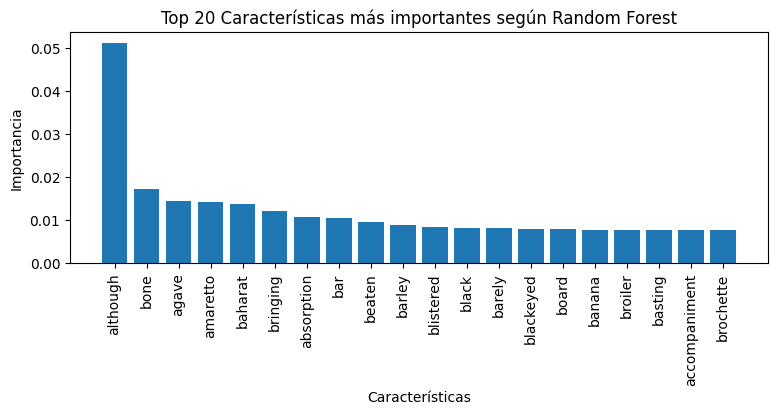

In [ ]:
# Obtener los nombres de las características del vectorizador
feature_names = tfidf.get_feature_names_out()

# Obtener las importancias de las características del modelo Random Forest
importances = model_kbest.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Número de características más importantes a mostrar
top_n = 20
top_indices = indices[:top_n]

# Crear un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.title("Top 20 Características más importantes según Random Forest")#la info que aportan al árbol de división
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

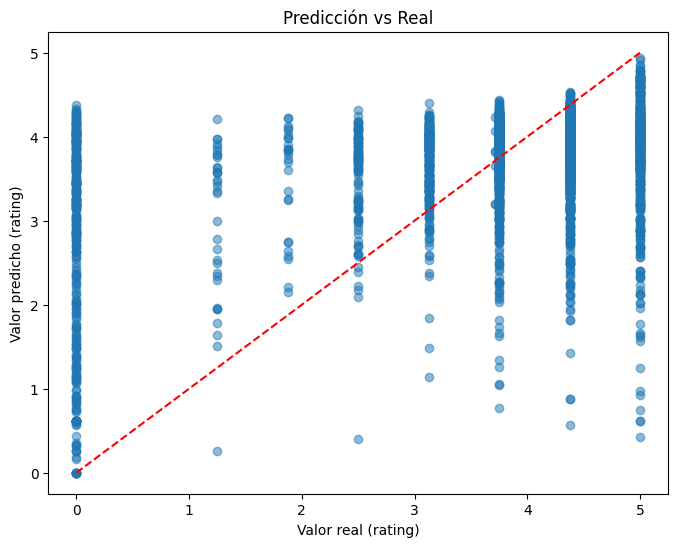

In [ ]:
#comparación valores reales vs valores predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_kbest, alpha=0.5)
plt.plot([0, 5], [0, 5], '--', color='red')  # Línea de referencia
plt.xlabel("Valor real (rating)")
plt.ylabel("Valor predicho (rating)")
plt.title("Predicción vs Real")
plt.show()

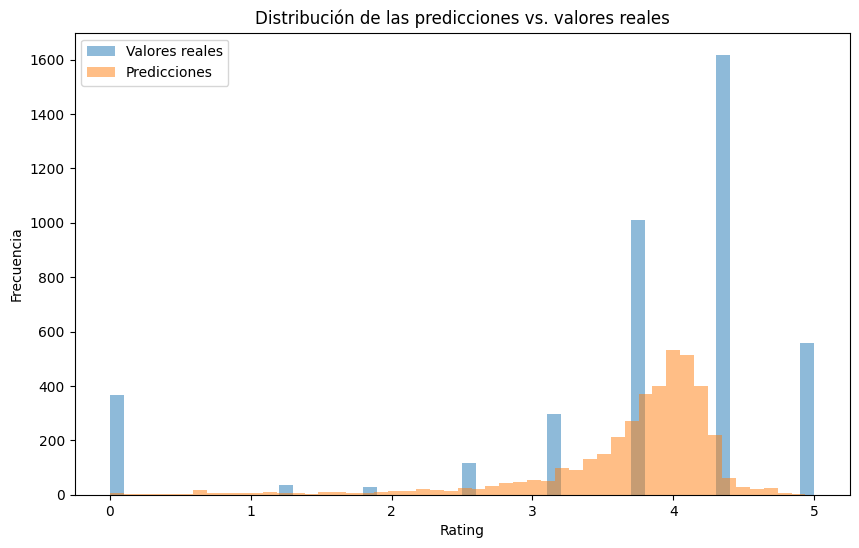

In [ ]:
#distribución valores reales rating vs predicciones
# Comparar distribuciones de las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label="Valores reales")
plt.hist(y_pred_kbest, bins=50, alpha=0.5, label="Predicciones")
plt.title("Distribución de las predicciones vs. valores reales")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()